<a href="https://colab.research.google.com/github/alexanderdrent/Uncertainty-Analysis-Windmaster/blob/master/python_src/Windmaster_DREAM_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ema_workbench
from ema_workbench.analysis import parcoords
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

     |████████████████████████████████| 23.7MB 69.8MB/s 
  Created wheel for ema-workbench: filename=ema_workbench-2.0.8-cp36-none-any.whl size=23772558 sha256=5bc0bf25e55eae472d31b84d3fedeb75de8059a78f6ca48a11d43cea94c06d3a
  Stored in directory: /root/.cache/pip/wheels/62/ef/66/b32ebb75d741a7582de4a92dff6a0c9ffe84454919e8a12bfa
Successfully built ema-workbench


/usr/local/lib/python3.6/dist-packages/ema_workbench/em_framework/evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
/usr/local/lib/python3.6/dist-packages/ema_workbench/em_framework/optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks')

In [ ]:
nchains = 3
old_samples = {}
log_ps = {}
for chain in range(nchains):
    old_samples[chain] = np.load(f'../EPA/Master Thesis/Results/Chains_500_iterations/wm_model_sampled_params_chain_{chain}_500.npy')
    log_ps[chain] = np.load(f'../EPA/Master Thesis/Results/Chains_500_iterations/wm_model_logps_chain_{chain}_500.npy')
vars = ["decisionMakingModel",
        "timing CCS",
        "offshore wind growth",
        "BOILER paths",
        "FURNACE paths",
        "COGEN paths",
        "leadtime_factor"]

burnin = int(len(old_samples[0]) / 5)
samples = np.vstack((old_samples[0][burnin:, :], old_samples[1][burnin:, :], old_samples[2][burnin:, :]))
log_ps = np.vstack((log_ps[0][burnin:, :], log_ps[1][burnin:, :], log_ps[2][burnin:, :]))

samples_df = pd.DataFrame(samples, columns = vars)
samples_df['decisionMakingModel'] = np.floor(samples_df.decisionMakingModel).astype(int)
#samples_df['decisionMakingModel_cat'] = pd.Categorical.from_codes(np.floor(samples_df.decisionMakingModel).astype(int), categories=["Reactive", "Current", "Proactive", "Collaborative"], ordered=True)
samples_df['offshore wind growth'] = np.round(samples_df['offshore wind growth']).astype(bool)
samples_df[['offshore wind growth', 'timing CCS','BOILER paths', 'FURNACE paths', 'COGEN paths']] = np.floor(samples_df[['offshore wind growth','timing CCS','BOILER paths', 'FURNACE paths', 'COGEN paths']]).astype(int)

color = "#9B2D1F"
sns.set(style="white")

In [ ]:
def save_fig(fig, name,dir='../EPA/Master Thesis/Results/Figures/DREAM',dpi=300):
    fig.savefig('{}/fig_{}_{}dpi.png'.format(dir, name, dpi), dpi=dpi, 
                bbox_inches='tight', format='png')

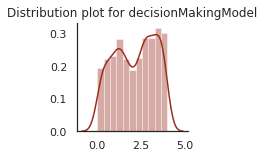

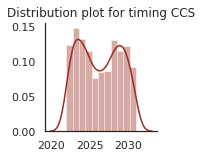

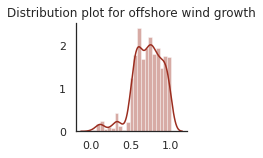

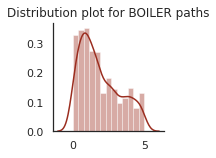

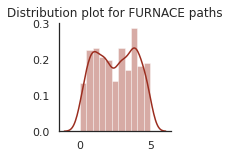

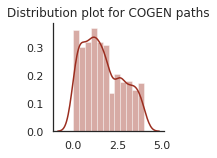

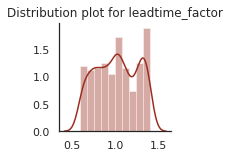

In [ ]:
for dim in range(len(vars)):
    fig, ax = plt.subplots(figsize=(2,2))
    ax = sns.distplot(samples[:, dim], color=color, norm_hist=True)
    ax.set_title(f"Distribution plot for {vars[dim]}")
    sns.despine()
    plt.show()
    save_fig(fig, name=f'dist_plot_{dim}')

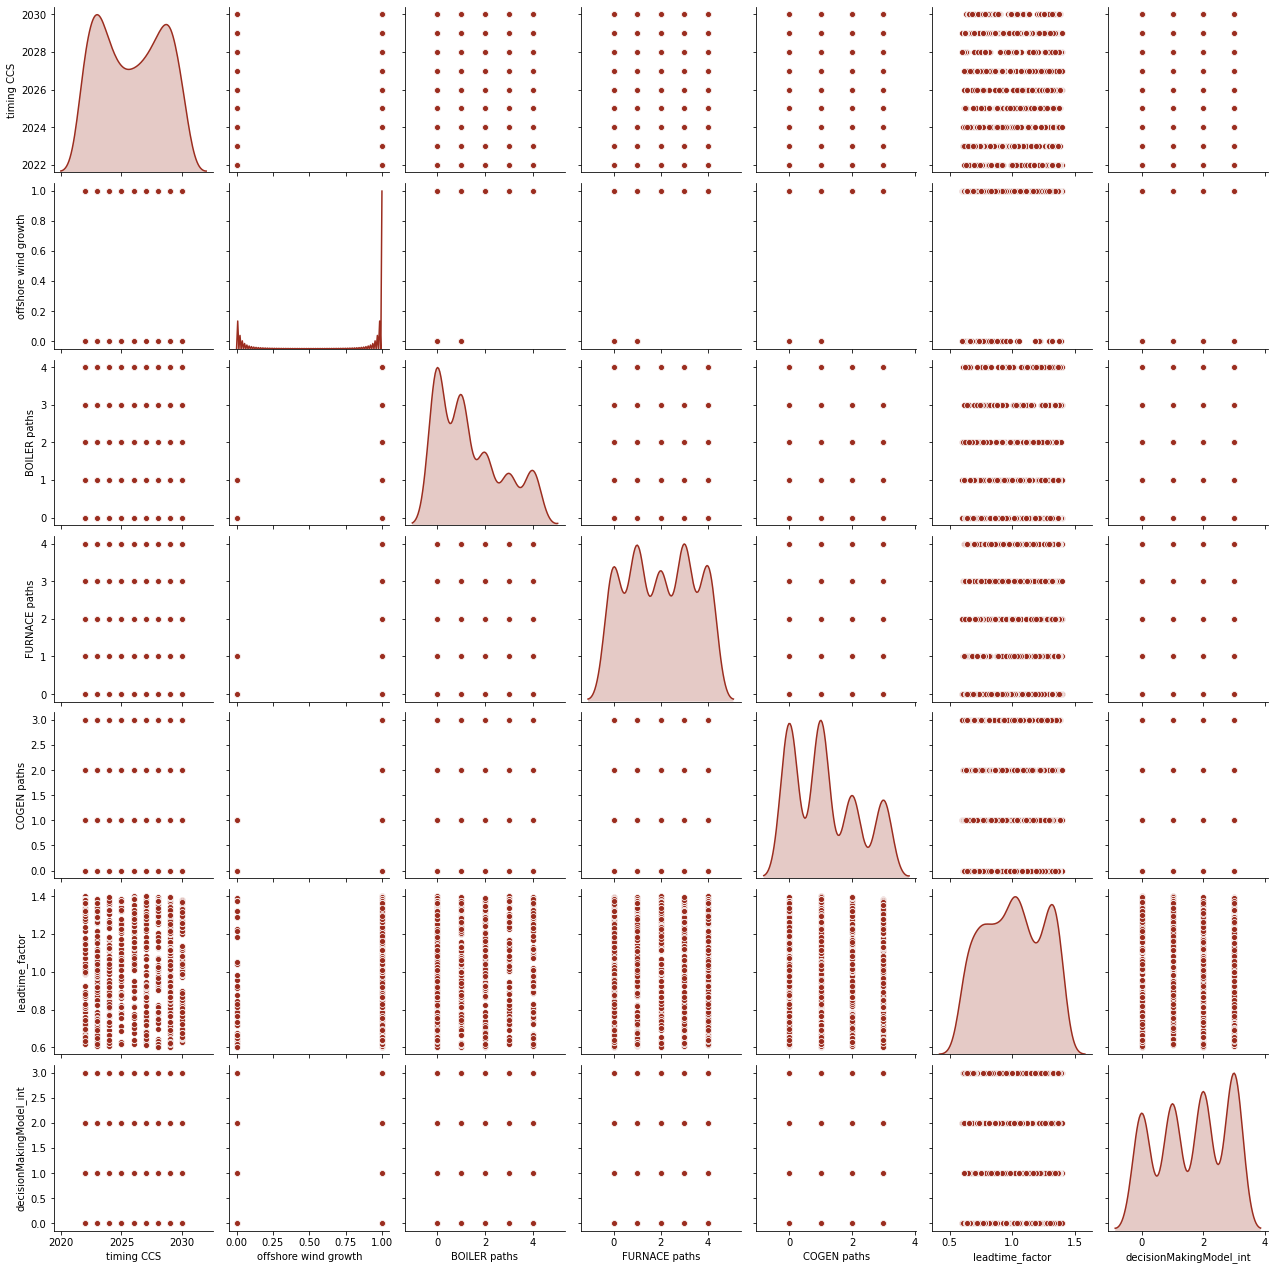

In [ ]:
pairgrid = sns.pairplot(samples_df,
                        kind= 'scatter',
                        diag_kind="kde",
                        plot_kws={'color':color},
                        diag_kws={'shade':True, 'color':color})
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/_kernel_base.py:516: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1483: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1484: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1132: Runtim

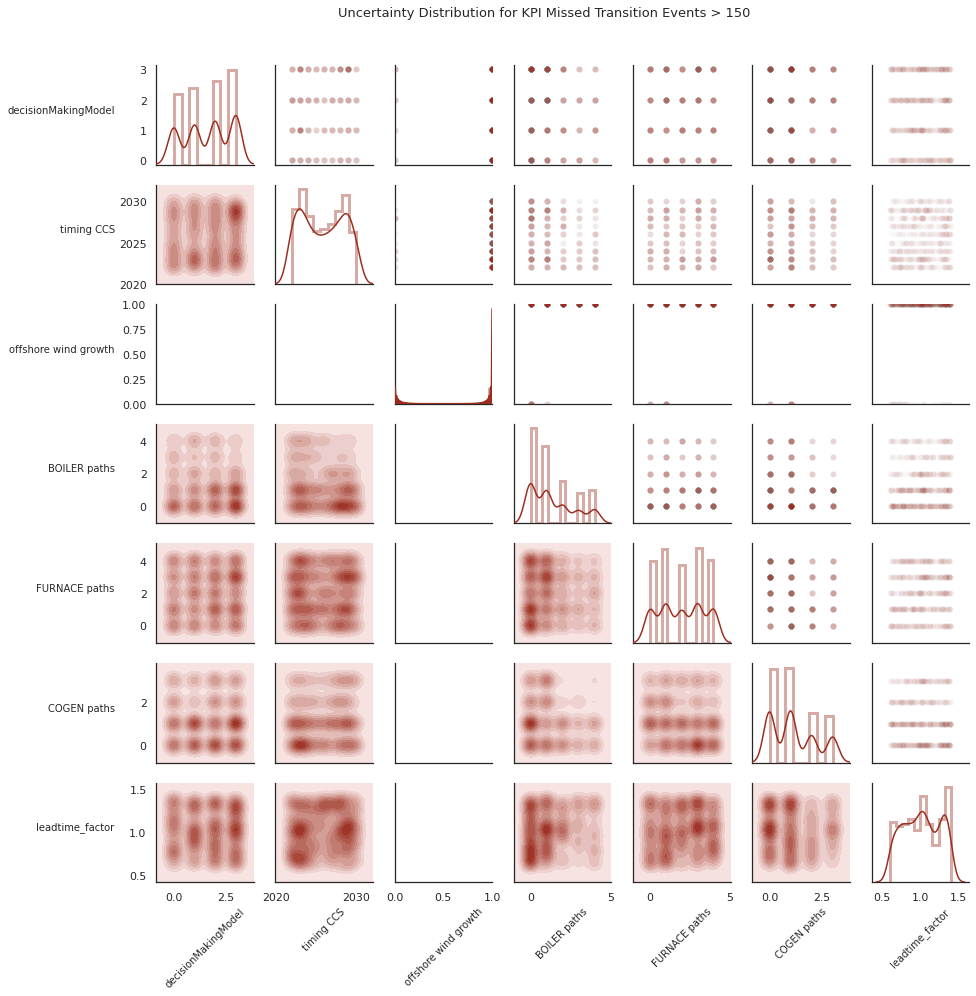

In [ ]:
g = sns.PairGrid(samples_df, diag_sharey=False, height=2)
g.map_upper(sns.scatterplot, color = color, alpha=0.01)
g.map_lower(sns.kdeplot, color = color, shade=True)
g.map_diag(sns.distplot, color=color, norm_hist=True, kde = True, hist_kws={"histtype": "step", "linewidth": 3})
g.fig.suptitle('Uncertainty Distribution for KPI Missed Transition Events > 150', fontsize=13, y = 1.05)
g.fig.set_size_inches((12,12))
for ax in g.axes.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation=45, size=10)
    ax.set_ylabel(ax.get_ylabel(), rotation=0, size=10, ha='right')
g.fig.align_ylabels()
plt.show()

save_fig(g.fig, name='pairgrid_samples')

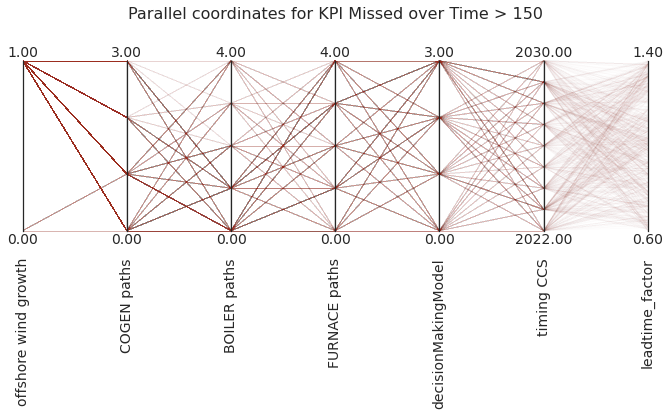

In [ ]:
def parallel_coords(data, hue=None, vars=None, legend=False,
                    limits=None, **kwargs):
    if limits is None:
        limits = parcoords.get_limits(data)        
    paraxes = parcoords.ParallelAxes(limits)
    paraxes.plot(data, **kwargs)

sequence = ['offshore wind growth', 'COGEN paths', 'BOILER paths', 'FURNACE paths', 'decisionMakingModel', 'timing CCS', 'leadtime_factor']
data=samples_df[sequence]
ax = parallel_coords(data, lw=1, alpha=0.01, color=color)
fig = plt.gcf()
fig.set_size_inches((10,8))
fig.suptitle("Parallel coordinates for KPI Missed over Time > 150", size = 16, y=1.02)
plt.show()

save_fig(fig, name='parallel_coordinates_samples')

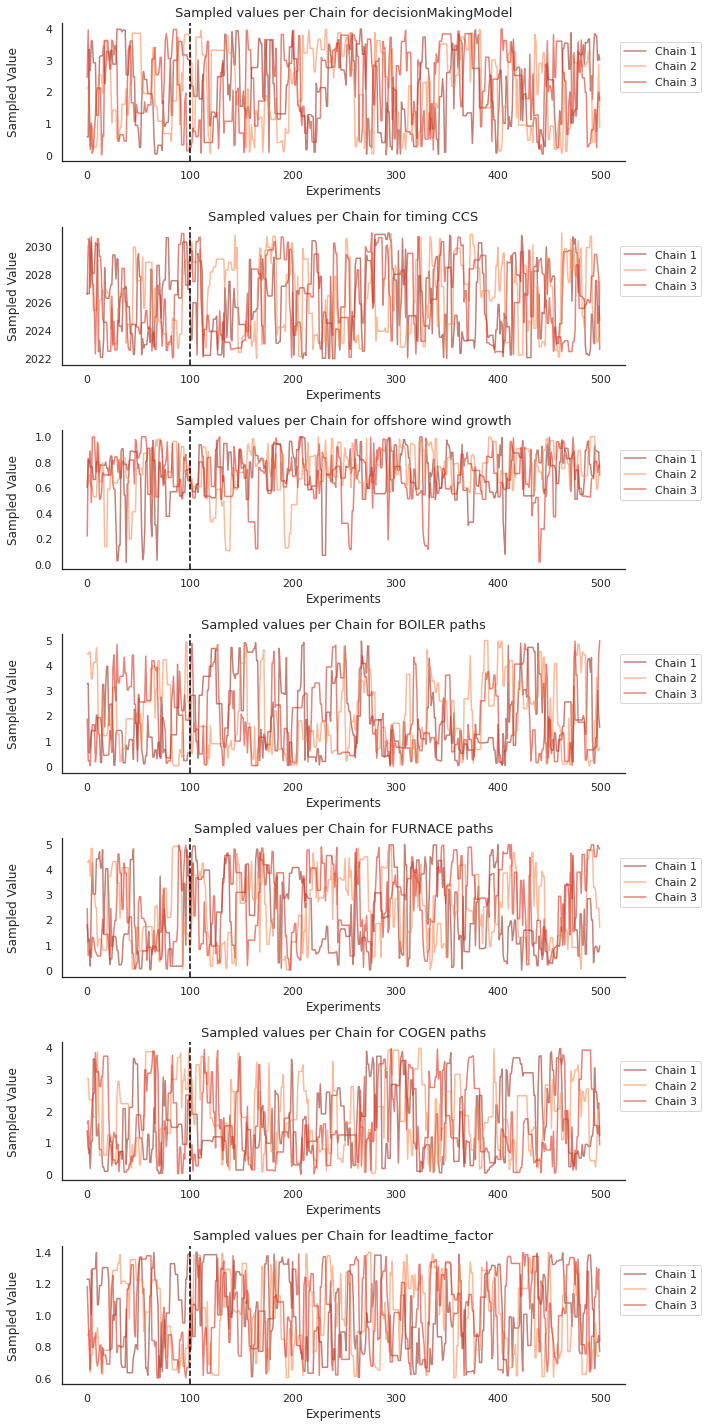

In [ ]:
samples_chain = {}
for chain in range(nchains):
    samples_chain[chain] = pd.DataFrame(old_samples[chain], columns=vars)

colors = ['#9B2D1F', '#fc8d59', '#d7301f']
fig, axes = plt.subplots(7,1)
for axnr, unc in enumerate(vars):
  for chain in range(nchains):
    samples_chain[chain][[unc]].plot(figsize=(20,3), ax=axes[axnr], c=colors[chain], alpha=0.6)
  axes[axnr].axvline(100, **{'linestyle': '--', 'color': "black"})
  axes[axnr].legend(bbox_to_anchor=(0.98, 0.9), fancybox=True, shadow=False, labels=['Chain 1', 'Chain 2', 'Chain 3'])
  axes[axnr].set_title(f'Sampled values per Chain for {unc}', size=13)
  axes[axnr].set_xlabel("Experiments", size=12)
  axes[axnr].set_ylabel("Sampled Value", size=12)
fig.set_size_inches (10,20)
fig.tight_layout()
fig.align_ylabels()
sns.despine()
plt.show()

save_fig(fig, name='samples_per_chain')